<a href="https://colab.research.google.com/github/OvinduWijethunge/Machine_Learning_Projects/blob/version-1/youtube%20spam%20classifier/Xgboost%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#url = 'https://raw.githubusercontent.com/OvinduWijethunge/Machine_Learning_Projects/version-1/youtube%20spam%20classifier/model.csv'
#df = pd.read_csv(url)
df = pd.read_csv('models.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sim_comment,word_count,duplicate_word_ratio,length_of_comment,stop_word_ratio,post_coment_gap,black_word_count,comment_duplication,...,num_of_punctuations_1.0,num_of_punctuations_2.0,num_of_punctuations_3.0,num_of_punctuations_4.0,num_of_punctuations_5.0,num_of_punctuations_6.0,is_period_sequence_1,is_link_1,is_youtube_link_1,is_number_1
0,0,-1.038590,-0.870409,1.866549,0.0000,4.274240,0.000000,13.337643,0.222222,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,-1.103307,-0.971247,1.866549,0.0000,4.555200,0.111111,29.017218,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
2,2,-1.064844,-0.957045,2.260334,0.0625,5.086086,0.062500,29.017218,0.125000,0.0,...,0,0,0,1,0,0,0,1,1,0
3,3,-0.936203,-0.910982,1.683387,0.0000,3.982309,0.142857,29.017218,0.142857,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,-1.212501,-1.085031,2.122197,0.0000,4.920915,0.000000,29.017218,0.076923,0.0,...,0,0,0,1,0,0,1,1,1,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sim_comment', 'word_count',
       'duplicate_word_ratio', 'length_of_comment', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'comment_duplication', 'is_spam',
       'no_of_sentences_2', 'no_of_sentences_3', 'num_of_punctuations_1.0',
       'num_of_punctuations_2.0', 'num_of_punctuations_3.0',
       'num_of_punctuations_4.0', 'num_of_punctuations_5.0',
       'num_of_punctuations_6.0', 'is_period_sequence_1', 'is_link_1',
       'is_youtube_link_1', 'is_number_1'],
      dtype='object')

#### Standardization  is no need for xgboost

In [5]:
dfc = df.copy()

In [6]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [7]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

X = X_ns
y = y_ns

The number of classes before fit Counter({0: 6255, 1: 712})
The number of classes after fit Counter({0: 6255, 1: 5629})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Hyperparameter Tuninng


In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [12]:
grid = {
    
    'max_depth':range(3,50),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [13]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [15]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 50),
                                        'min_child_weight': range(1, 20),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   return_train_score=True, scoring='accuracy', verbose=2)

#### Evaluvate ( accuracy, recall, precision, f1 score, ROC curve/ AUC)

In [16]:
best_model = xgb_random.best_estimator_

In [17]:
best_model

XGBClassifier(colsample_bytree=0.6, gamma=0.4, max_depth=20, reg_alpha=0.01,
              subsample=0.7)

In [18]:
xgb_random.best_params_

{'subsample': 0.7,
 'reg_alpha': 0.01,
 'min_child_weight': 1,
 'max_depth': 20,
 'gamma': 0.4,
 'colsample_bytree': 0.6}

In [19]:
xgb_random.best_score_

0.9823271024252523

In [20]:
#xgb_random.score(X_train)

In [21]:
y_pred = best_model.predict(X_test)

In [22]:
err  =(y_pred- y_test)

<AxesSubplot:>

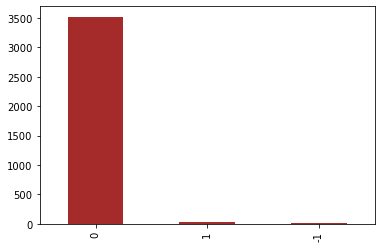

In [23]:
err.value_counts().plot(kind='bar',color='brown')

In [24]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.012619181155356141
MSE: 0.012619181155356141
RMSE: 0.11233512876814689


In [25]:
#indices=list(X_train)
#feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Importance of Features')
#plt.ylabel('Feature Importance Score')

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1860   39]
 [   6 1661]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1899
           1       0.98      1.00      0.99      1667

    accuracy                           0.99      3566
   macro avg       0.99      0.99      0.99      3566
weighted avg       0.99      0.99      0.99      3566



In [28]:
print("accuracy is {}".format(best_model.score(X_test, y_test)))

accuracy is 0.9873808188446439


In [ ]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

### ROC

In [29]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [31]:
baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

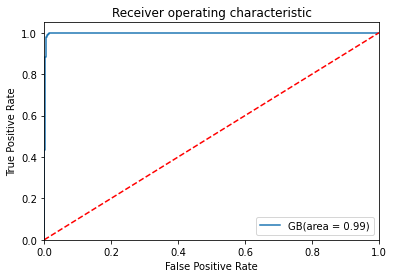

In [32]:
plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

(0.0, 1.0)

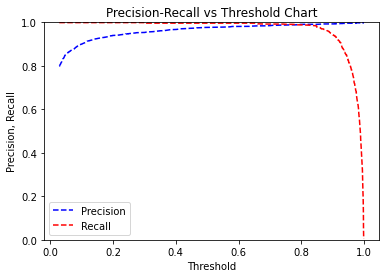

In [34]:
### Predict test_y values and probabilities based on xgboost model
probs_y=best_model.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [ ]:
# IN spam classification domain we should much concern about reduce the False Positives, for that we have to increase Precision

### After evaluate your best model among from all models then you can change the threshold of chosen model as your requirements as below

In [ ]:
#THRESHOLD = 0.6
#y_pred = np.where(best_model.predict_proba(X_test.values)[:,1] > THRESHOLD, 1, 0)

In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [ ]:
# we should choose the treshold according to our reqiurement

In [ ]:
# when you go to production mode,
# you should save the model
# you should save the scaler object
# should add your custom threshold value when you predict

In [35]:
import pickle
# open a file, where you ant to store the data
file = open('xgboost_Classifierv2.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()